In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import re
import random
from pathlib import Path
import time
import dotenv
import warnings
import datetime

from tqdm import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from mp_api.client import MPRester
from pymatgen.core import Structure
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from ase.visualize import view

warnings.filterwarnings("ignore")

In [3]:
dir_mp = Path(".")

# 1. Materials Project

Save your materials project API key in a .env file in the same directory as this notebook. The file should look like this:

```
MP_API_KEY=your_api_key
```

In [4]:
dotenv.load_dotenv()
MP_API_KEY = os.getenv("MP_API_KEY")

### 1.1 Retrieving created_at from the Materials Project API

`created_at` is only available in the `mpr.materials.search`, so we will use this function to retrieve the registration date of the materials.

In [22]:
with MPRester(MP_API_KEY) as mpr:
    total_docs = mpr.materials.search(
        num_sites=[40, 50],
        fields=[
            "material_id",
            "created_at",
        ],
    )

Retrieving MaterialsDoc documents:   0%|          | 0/12458 [00:00<?, ?it/s]

In [12]:
len(total_docs)

127817

In [17]:
data = []
for doc in total_docs:
    data.append(
        {
            "material_id": doc.material_id,
            "created_at": doc.created_at,
        }
    )
df_mp_created_at = pd.DataFrame(data)
# remove duplicates
df_mp_created_at = df_mp_created_at.drop_duplicates(subset=["material_id"])
# save to csv
df_mp_created_at.to_csv(dir_mp / "mp-created-at.csv", index=False)

### 1.2. Donwload snapshot with constraints of num_sites <= 40 and energy convex hull <= 0.25 eV and experimental = True

In [18]:
with MPRester(MP_API_KEY) as mpr:
    docs = mpr.summary.search(
        num_sites=[0, 40],
        energy_above_hull=[0, 0.25],
        theoretical=False,
        fields=[
            "material_id",
            "structure",
            "energy_above_hull",
            "band_gap",
            "theoretical",
        ],
    )

Retrieving SummaryDoc documents: 100%|██████████| 33476/33476 [00:44<00:00, 751.46it/s]


In [19]:
excluded_gas_list = [
    "H",
    "He",
    "N",
    "O",
    "F",
    "Ne",
    "Cl",
    "Ar",
    "Kr",
    "Xe",
    "Rn",
    "Fr",
    "Og",
]

In [21]:
data = []
for doc in tqdm(docs):
    st = doc.structure
    elements = [elmt.symbol for elmt in st.composition.elements]

    if len(elements) == 1 and elements[0] in excluded_gas_list:
        # print(elements)
        continue

    if max(st.lattice.abc) > 20:
        # print(st.formula, st.lattice.abc)
        continue

    row = {
        "material_id": doc.material_id,
        "energy_above_hull": doc.energy_above_hull,
        "band_gap": doc.band_gap,
        "cif": st.to(fmt="cif"),
    }
    data.append(row)

df_mp_api = pd.DataFrame(data)
# remove duplicates
df_mp_api = df_mp_api.drop_duplicates(subset="material_id")
# shuffle
df_mp_api = df_mp_api.sample(frac=1, random_state=69).reset_index()
# save to csv
df_mp_api.to_csv(dir_mp / "mp-api.csv", index=False)

100%|██████████| 33476/33476 [00:42<00:00, 783.46it/s] 


In [5]:
# calculate properties
from pandarallel import pandarallel

pandarallel.initialize(progress_bar=True)


def calculate_property(data):
    from pymatgen.core import Structure
    from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
    
    st = Structure.from_str(data.cif, fmt="cif")
    sg = SpacegroupAnalyzer(st, symprec=0.1)
    data["composition"] = st.composition.reduced_composition.alphabetical_formula
    data["volume"] = st.volume
    data["density"] = st.density
    data["atomic_density"] = st.density
    data["crystal_system"] = sg.get_crystal_system()
    data["space_group_symbol"] = sg.get_space_group_symbol()
    data["space_group_number"] = sg.get_space_group_number()
    return data


df_mp_api = pd.read_csv(dir_mp / "mp-api.csv")
df_mp_total = df_mp_api.parallel_apply(calculate_property, axis=1)
df_mp_total.to_csv(dir_mp / "mp-total.csv", index=False)

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


### 1.3. Make test set registered after 

In [6]:
# merge created_at
df_mp_created_at = pd.read_csv(dir_mp / "mp-created-at.csv")
df_mp_total = pd.read_csv(dir_mp / "mp-total.csv")
df_mp_total = pd.merge(df_mp_total, df_mp_created_at, on="material_id")
print(len(df_mp_total))

32943


<Axes: title={'center': 'Materials Project API'}, xlabel='Year', ylabel='Number of Entries'>

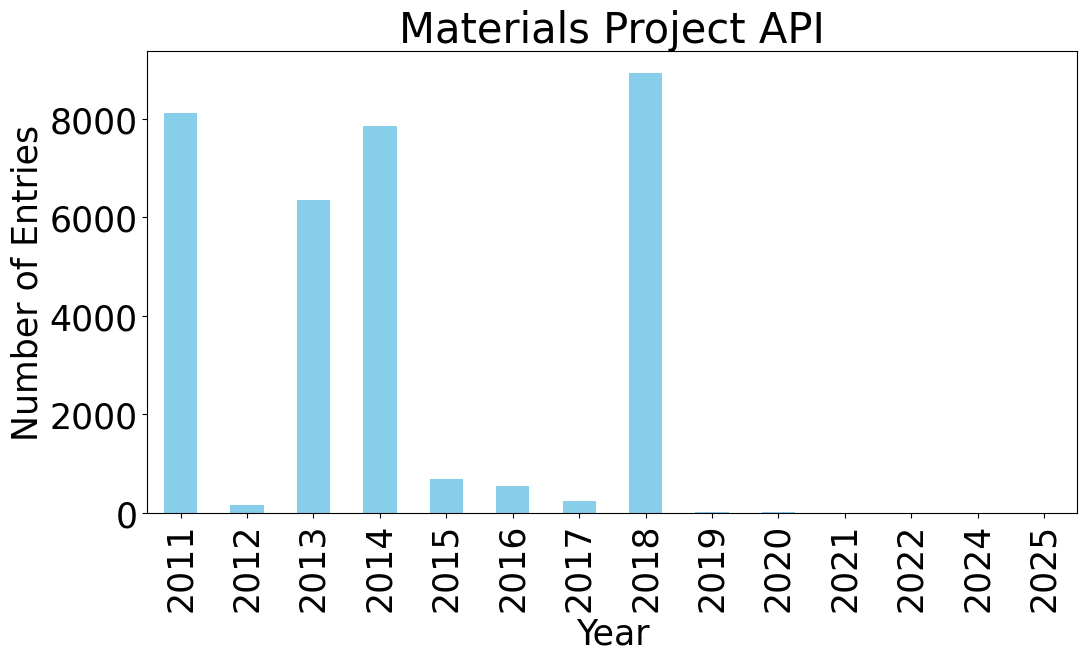

In [7]:
# plot according to the year
plt.rcParams["font.size"] = 25
df_mp_total["created_at"].apply(lambda x: int(x[:4])).value_counts().sort_index().plot(
    kind="bar",
    color="skyblue",
    title="Materials Project API",
    figsize=(12, 6),
    xlabel="Year",
    ylabel="Number of Entries",
)

In [9]:
df_mp_total["created_at"]

0               2014-02-19 17:11:33+00:00
1               2011-05-28 13:10:38+00:00
2               2014-02-26 00:09:14+00:00
3               2011-05-28 08:19:57+00:00
4        2018-07-19 06:28:52.188000+00:00
                       ...               
32938           2011-06-03 07:49:37+00:00
32939    2018-07-20 12:14:42.123000+00:00
32940    2018-07-20 08:11:31.945000+00:00
32941           2014-01-19 06:48:42+00:00
32942           2014-02-22 09:09:57+00:00
Name: created_at, Length: 32943, dtype: object

In [ ]:
from datetime import datetime


def convert_to_datetime(date_str):
    try:
        # with microseconds
        return datetime.strptime(date_str, "%Y-%m-%d %H:%M:%S.%f%z")
    except ValueError:
        # without microseconds
        return datetime.strptime(date_str, "%Y-%m-%d %H:%M:%S%z")


df_mp_total["created_at_datetime"] = df_mp_total["created_at"].apply(
    convert_to_datetime
)



In [23]:
cutoff_date = pd.to_datetime("2018-08-04", utc=True)
df_train_val = df_mp_total[df_mp_total["created_at_datetime"] < cutoff_date]

In [25]:
num_val = int(len(df_train_val) * 0.1)
df_train = df_train_val.iloc[:-num_val]
df_val = df_train_val.iloc[-num_val:]

print(len(df_train))
print(len(df_val))

28971
3218


In [26]:
df_test = df_mp_total[df_mp_total["created_at_datetime"] >= cutoff_date]

In [27]:
len(df_test)

754

In [ ]:
# # train val
# df_train_val = df_mp_total[df_mp_total["created_at_datetime"] < cutoff_date]
# num_val = int(len(df_train_val) * 0.1)
# df_train = df_train_val.iloc[:-num_val]
# df_val = df_train_val.iloc[-num_val:]
# # test
# df_test = df_mp_total[df_mp_total["created_at_datetime"] >= cutoff_date]
# print(len(df_train), len(df_val), len(df_test))

In [31]:
df_train = df_mp_total[df_mp_total["created_at_datetime"] >= cutoff_date]
cut = df_mp_total[df_mp_total["created_at_datetime"] < cutoff_date]
num_val = int(len(df_train_val) * 0.1)
x = df_train_val.iloc[-num_val:]


In [34]:
actual_train = pd.concat([df_train, x])

In [37]:
actual_train

,index,material_id,energy_above_hull,band_gap,cif,composition,volume,density,atomic_density,crystal_system,space_group_symbol,space_group_number,created_at,created_at_datetime
22,1614,mp-1205371,0.013001,2.8257,# generated using pymatgen\ndata_Ba3InS4Cl\n_s...,Ba3 Cl1 In1 S4,523.834952,4.377799,4.377799,tetragonal,I4/mcm,140,2018-08-06 04:44:19.796000+00:00,2018-08-06 04:44:19.796000+00:00
42,3490,mp-1182001,0.037071,3.4780,# generated using pymatgen\ndata_Ca3V2O8\n_sym...,Ca3 O8 V2,173.647389,3.348020,3.348020,monoclinic,C2/m,12,2018-08-16 00:34:20.862000+00:00,2018-08-16 00:34:20.862000+00:00
48,8382,mp-1203663,0.074750,0.0000,# generated using pymatgen\ndata_Er2Co12Ni5\n_...,Co12 Er2 Ni5,478.592954,9.265177,9.265177,hexagonal,P6_3/mmc,194,2018-08-04 17:44:42.147000+00:00,2018-08-04 17:44:42.147000+00:00
96,13264,mp-1180658,0.099367,0.0000,# generated using pymatgen\ndata_KTiO3\n_symme...,K1 O3 Ti1,281.091182,3.189174,3.189174,hexagonal,P6_3/mmc,194,2018-08-15 20:02:29.931000+00:00,2018-08-15 20:02:29.931000+00:00
128,25534,mp-1203262,0.042395,4.1659,# generated using pymatgen\ndata_SiH12C4(N5F3)...,C4 F6 H12 N10 Si1,311.683201,1.823553,1.823553,triclinic,P-1,2,2018-08-04 15:54:44.758000+00:00,2018-08-04 15:54:44.758000+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32938,9225,mp-15895,0.009456,0.8804,# generated using pymatgen\ndata_Cu2SiS3\n_sym...,Cu2 S3 Si1,213.300025,3.913866,3.913866,monoclinic,Cc,9,2011-06-03 07:49:37+00:00,2011-06-03 07:49:37+00:00
32939,11825,mp-1192487,0.018489,0.0000,# generated using pymatgen\ndata_Ho5Mg24\n_sym...,Ho5 Mg24,701.012458,3.335164,3.335164,cubic,I-43m,217,2018-07-20 12:14:42.123000+00:00,2018-07-20 12:14:42.123000+00:00
32940,25015,mp-1191428,0.000000,0.0000,# generated using pymatgen\ndata_Sc2Co12P7\n_s...,Co12 P7 Sc2,245.758373,6.850894,6.850894,hexagonal,P-6,174,2018-07-20 08:11:31.945000+00:00,2018-07-20 08:11:31.945000+00:00
32941,9818,mp-743577,0.130201,4.3131,# generated using pymatgen\ndata_FeH12C2S2(O2F...,C2 F6 Fe1 H12 O12 S2,429.527602,1.786366,1.786366,monoclinic,C2/m,12,2014-01-19 06:48:42+00:00,2014-01-19 06:48:42+00:00


In [42]:
train_df = actual_train.sample(n=1000, random_state=67)

# Drop the training rows and sample 1000 for testing
remaining_df = actual_train.drop(train_df.index)
test_df = remaining_df.sample(n=500, random_state=21)

# Drop train+test rows and sample 500 for validation
remaining_df = remaining_df.drop(test_df.index)
val_df = remaining_df.sample(n=500, random_state=42)

In [46]:
# save
train_df.to_csv(dir_mp / "train.csv", index=False)
val_df.to_csv(dir_mp / "val.csv", index=False)
test_df.to_csv(dir_mp / "test.csv", index=False)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(24, 12))
df_train["crystal_system"].value_counts().sort_index().plot(
    kind="bar", color=sns.color_palette("pastel")[0], ax=axes[0], title="Train"
)
df_test["crystal_system"].value_counts().sort_index().plot(
    kind="bar", color=sns.color_palette("pastel")[1], ax=axes[1], title="Test"
)

# 2. Text Prompts

In [ ]:
# ! generate_text_prompt.py

In [5]:
path_prompts = Path("./prompts/")  # TODO: change the path
text_files = list(path_prompts.glob("*.txt"))

# read and make df
prompts = {}
for text_file in text_files:
    material_id = text_file.stem
    with open(text_file, "r") as f:
        text = f.read()
        revised_text = re.sub(r"\d+\.\s", "", text)
        text_prompts = revised_text.split("\n")
        prompt = random.choice(text_prompts)  # select one prompt randomly
        prompts[material_id] = prompt



In [6]:
df_prompts = pd.DataFrame(prompts.items(), columns=["material_id", "prompt"])

In [8]:
# update trian, test, val
for split in ["train", "val", "test"]:
    df = pd.read_csv(dir_mp / f"{split}.csv")
    df = pd.merge(df, df_prompts, on="material_id")
    df.to_csv(dir_mp / f"{split}.csv", index=False)

# Info lattice matrix

In [97]:
df_train = pd.read_csv(dir_mp / "train.csv")
st_list = [Structure.from_str(cif, fmt="cif") for cif in df_train["cif"]]

In [101]:
lattice_params = np.array([st.lattice.parameters for st in st_list])
lattice_params_mean = lattice_params.mean(axis=0)
lattice_params_std = lattice_params.std(axis=0)
print(lattice_params_mean, lattice_params_std)

In [105]:
# write
lattice_params_mean = lattice_params_mean.tolist()
lattice_params_std = lattice_params_std.tolist()
with open(dir_mp / "lattice_params.txt", "w") as f:
    f.write(f"mean: {lattice_params_mean}\n")
    f.write(f"std: {lattice_params_std}\n")